# [延伸閱讀](https://www.thenewslens.com/article/130173?fbclid=IwAR3EZ1OjBKz4L1ZCC7pZT-LJ71pFvNt_e5AbKJCEV_0uboX_z5HOEZaFkSs)

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
import sklearn.decomposition # 特徵擷取降維
import os
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # 中文輸出(台北黑體)
%matplotlib inline
import pickle

# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 50)

In [2]:
def read_party_vote(file_path):
    cols = ['行政區', '村里', '投票所', '合一行動聯盟', '中華統一促進黨', '親民黨', '安定力量', '台灣基進', '時代力量', '新黨', '喜樂島聯盟', '中國國民黨', '一邊一國行動黨', '勞動黨', '綠黨', '宗教聯盟', '民主進步黨', '台灣民眾黨', '台灣維新', '台澎黨', '國會政黨聯盟', '台灣團結聯盟']
    
    df = pd.read_excel(file_path)
    df = df.iloc[5:, :22]
    df.columns = cols

    dft = df.T

    area = '' # 補上 '村里'的'行政區'
    for i in dft:
        if type(dft[i]['村里']) == float:
            area = dft[i]['行政區'][1:]
        else:
            df['行政區'][i] = area

    df = df[df['村里'].notnull()]
    
    # 留下需要的 columns
    cols = ['行政區', '村里', '投票所', '親民黨', '台灣基進', '時代力量', '中國國民黨', '民主進步黨', '台灣民眾黨']
    df = df.reset_index()[cols]
    # 票數是字串 需要移除 ',' 並組合轉成 (int)
    cols = ['親民黨', '台灣基進', '時代力量', '中國國民黨', '民主進步黨', '台灣民眾黨']
    for p in cols:
        df[p] = df[p].str.split(',').str.join('')
    # 轉成int
    df[cols] = df[cols].astype(float)
    # 轉成每一里的比例
#     df[cols] = (df[cols].T / df[cols].sum(1) * 100).T

    df['key'] = df['行政區'] + df['村里'] + df['投票所']

    return df

def read_vote(file_path):
    cols = ['行政區', '村里', '投票所', '宋', '韓', '蔡']

    df = pd.read_excel(file_path)
    df = df.iloc[5:, 0:6]
    df.columns = cols
    dft = df.T

    area = ''
    for i in dft:
        if type(dft[i]['村里']) == float:
            area = dft[i]['行政區'][1:]
        else:
            df['行政區'][i] = area

    df = df[df['村里'].notnull()].reset_index()[cols]
    
    # 票數是字串 需要移除 ',' 並組合轉成 (int)
    cols = ['宋', '韓', '蔡']
    for p in cols:
        df[p] = df[p].str.split(',').str.join('')
    # 轉成int
    df[cols] = df[cols].astype(float)
    # 轉成每一里的比例
#     df[cols] = (df[cols].T / df[cols].sum(1) * 100).T

    df['key'] = df['行政區'] + df['村里'] + df['投票所']

    return df

### 總統剽和政黨票

In [3]:
p_df = read_vote('總統票/總統-A05-4-候選人得票數一覽表-各投開票所(臺中市).xls')
party_df = read_party_vote('立委票/不分區立委-A05-6-得票數一覽表(臺中市).xls')

In [16]:
# 獲取 台中第三選區 地方立委選票
df = pd.read_excel('立委票/區域立委-A05-2-得票數一覽表(臺中市).xls', sheet_name='臺中市第3選舉區')
cols = ['行政區', '村里', '投票所', '洪慈庸', '張睿倉', '楊瓊瓔']
df = df.iloc[5:, [0, 1, 2, 5, 6, 8]]
df.columns = cols

dft = df.T

area = '' # 補上 '村里'的'行政區'
for i in dft:
    if type(dft[i]['村里']) == float:
        area = dft[i]['行政區'][1:]
    else:
        df['行政區'][i] = area

df = df[df['村里'].notnull()].reset_index()[cols]

cols = ['洪慈庸', '張睿倉', '楊瓊瓔']

# 票數是字串 需要移除 ',' 並組合轉成 (int)
for p in cols: 
    df[p] = df[p].str.split(',').str.join('')
# 轉成int
df[cols] = df[cols].astype(float)
# 轉成每一里的比例
# df[cols] = (df[cols].T / df[cols].sum(1) * 100).T
df['投票所'] = '0' + df['投票所']
df['key'] = df['行政區'] + df['村里'] + df['投票所']
area_df = df

In [17]:
cols = ['key', '行政區', '村里', '洪慈庸', '張睿倉', '楊瓊瓔', '時代力量', '中國國民黨', '民主進步黨', '台灣民眾黨', '宋', '韓', '蔡']
df = area_df.merge(party_df, on='key')
df = df.merge(p_df, on='key')[cols]

df['key'] = df['行政區'] + df['村里']
# 同里不同投票所的組合
df = df.groupby('key').sum()
cols = df.columns

In [18]:
cols = ['洪慈庸', '張睿倉', '楊瓊瓔']
df[cols] = (df[cols].T / df[cols].sum(1) * 100).T
cols = ['時代力量', '中國國民黨', '民主進步黨', '台灣民眾黨']
df[cols] = (df[cols].T / df[cols].sum(1) * 100).T
cols = ['宋', '韓', '蔡']
df[cols] = (df[cols].T / df[cols].sum(1) * 100).T
cols = df.columns

In [19]:
# df[cols] = sklearn.preprocessing.minmax_scale(df.values)

In [21]:
Y_G = df.民主進步黨.values
Y_B = df.中國國民黨.values

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
洪慈庸 [-0.78523674] 0.5518596529974567
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
張睿倉 [-0.3258725] 0.020693378084456704
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
楊瓊瓔 [1.04559625] 0.8012356364650741


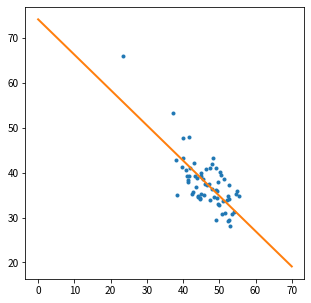

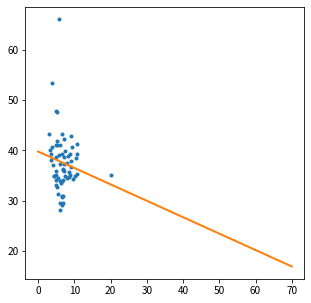

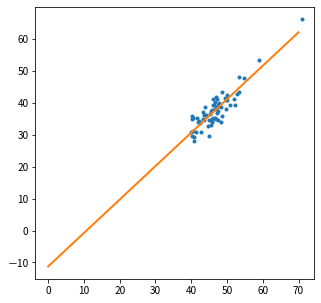

In [27]:
Y = Y_B
mod = sklearn.linear_model.LinearRegression()
for col in ['洪慈庸', '張睿倉', '楊瓊瓔']:
    X = df[[col]].values
    mod.fit(X, Y)
    print(mod)
    print(col, mod.coef_, mod.score(X, Y))
    
    line_x = np.linspace(0, 70, 2)
    line_y = mod.predict(line_x.reshape(-1, 1))
    plt.figure(figsize=(5, 5))
    plt.plot(X, Y, '.')
    plt.plot(line_x, line_y, lw=2)
#     plt.axis([0, 1.1, 0, 1.1])

In [28]:
# 分類不同勢力 (得票率都在同軸 並不能表現出不同, 投影到XY軸的三個方向(0, 90, 180度))
angle = np.linspace(0, np.pi, 3, endpoint=True)
G_B_T = [0, 1, 2, 1, 2, 0, 1, 1, 2, 0]
df = pd.concat([df * np.sin(angle[G_B_T]), df * np.cos(angle[G_B_T])])

Text(0, 0.5, 'PC 1')

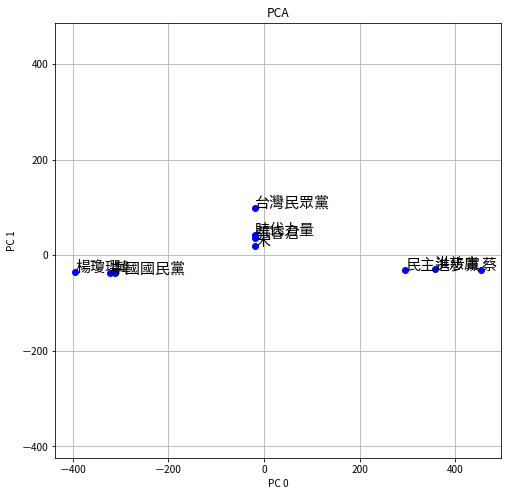

In [29]:
X = df.values.T

pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(X)
trans = pca.transform(X)

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.plot(trans[:, 0], trans[:, 1], 'bo')
for i, text in enumerate(cols):
    ax.text(trans[i, 0], trans[i, 1], text, fontsize=15)
ax.grid(True)
ax.axis('equal')
ax.set_title('PCA')
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")

In [30]:
print('主成分組成平方和\n', (pca.components_**2).sum(1))
print('PC 影響程度:\n', pca.explained_variance_ratio_)

主成分組成平方和
 [1. 1.]
PC 影響程度:
 [0.97236921 0.02491681]


In [31]:
trans.mean(0)

array([-5.68434189e-15, -6.39488462e-15])

In [32]:
df

,洪慈庸,張睿倉,楊瓊瓔,時代力量,中國國民黨,民主進步黨,台灣民眾黨,宋,韓,蔡
key,,,,,,,,,,
后里區中和里,0.000000,4.814004e+00,4.937444e-15,8.760545e+00,4.394742e-15,0.000000,1.563920e+01,4.508419e+00,4.210763e-15,0.000000
后里區仁里里,0.000000,3.103914e+00,5.949701e-15,7.131537e+00,5.298393e-15,0.000000,1.109350e+01,5.555556e+00,4.827311e-15,0.000000
后里區公館里,0.000000,3.679793e+00,5.716073e-15,8.908686e+00,4.654931e-15,0.000000,1.284336e+01,4.646722e+00,4.349796e-15,0.000000
后里區厚里里,0.000000,3.715170e+00,6.134608e-15,7.861190e+00,4.987053e-15,0.000000,1.579320e+01,5.156538e+00,4.818899e-15,0.000000
后里區后里里,0.000000,4.955437e+00,5.632065e-15,8.018092e+00,5.025483e-15,0.000000,1.574836e+01,5.374823e+00,4.798121e-15,0.000000
...,...,...,...,...,...,...,...,...,...,...
神岡區社南里,52.755308,4.256545e-16,-4.029323e+01,5.342182e-16,-2.948460e+01,45.551396,9.943864e-16,2.799980e-16,-2.891054e+01,66.516742
神岡區社口里,51.696015,4.188088e-16,-4.146432e+01,5.514674e-16,-3.091757e+01,42.826870,1.056222e-15,3.002026e-16,-3.105031e+01,64.047007
神岡區神岡里,47.922912,4.248239e-16,-4.513919e+01,4.651668e-16,-3.631151e+01,40.850454,9.332593e-16,2.570823e-16,-3.651399e+01,59.287532
